In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [3]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    #if probs == 0:
        #return 0
    #else:
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [4]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)
food

,Food ID,Survey ID,Food Name,Survey flag,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)",...,Total saturated fat (g),Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg)
0,10F40019,31103001,"Beef, extract, bonox",NaN,401,401,56.6,16.6,0.2,6.5,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00
1,13A12001,31302001,"Basil, dried",NaN,1079,774,10.0,18.2,5.5,15.5,...,2.36,1.40,0.61,0.26,0.34,0.00,0.00,0.0,0.000,0.00
2,10E10113,31302002,"Cardamom, seeds, ground",NaN,1333,1109,8.3,10.8,6.7,40.5,...,2.20,2.81,1.39,1.00,0.39,0.00,0.00,0.0,0.000,0.00
3,10E10098,31302003,Chilli (chili) powder,NaN,1441,1167,7.8,12.3,16.8,20.5,...,2.41,3.15,7.85,7.32,0.52,0.00,0.00,0.0,0.000,0.00
4,10E10107,31302004,"Chilli (chili), dried, ground",NaN,1573,1355,6.6,14.1,16.8,29.6,...,2.42,3.16,7.89,7.36,0.52,0.00,0.00,0.0,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,13A11950,24702010,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,352,340,85.8,1.2,7.6,2.3,...,0.52,4.24,2.04,1.37,0.65,0.00,0.00,0.0,0.000,2.05
5736,13A11949,24702011,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,352,340,85.8,1.2,7.6,2.3,...,1.10,5.09,0.62,0.59,0.03,0.00,0.00,0.0,0.000,0.00
5737,13A12055,24702012,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,347,335,85.9,1.2,7.4,2.3,...,1.18,4.18,1.29,1.12,0.17,0.07,0.36,0.0,0.425,51.68
5738,13A11848,24702013,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,77,66,93.8,1.1,0.4,2.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00


# 1. Feature Standardisation

In [5]:
##Question 1


###1a

#Updating the new DataFrame to exclude the first 4 columns
cont_food = food.drop(food.columns[[0, 1, 2, 3]],axis=1)

###1b

#Using standarscaler to scale the data in food dataframe with only continuous values
scaled_features = StandardScaler().fit_transform(cont_food.values)
foodscaled = pd.DataFrame(scaled_features, index=cont_food.index, columns=cont_food.columns)


###1c

#Creating a new DataFrame with all values in foodscaled in one column to calculate all the wanted values easily

cols = [foodscaled[col].squeeze() for col in foodscaled]
new_df = pd.concat(cols, ignore_index=True)


print ('***')
print ('Q1.c: foodscaled matrix details')
print("Number of rows:", round(foodscaled.shape[0], 1))
print("Number of columns:", round(foodscaled.shape[1], 1))
print(f"Min: {new_df.min():.1f}")
print(f"Max: {new_df.max():.1f}")
print(f"Mean: {-new_df.mean():.1f}")
print(f"Standard Deviation: {new_df.std():.1f}")
print('***')

food

***
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Standard Deviation: 1.0
***


,Food ID,Survey ID,Food Name,Survey flag,"Energy, with dietary fibre (kJ)","Energy, without dietary fibre (kJ)",Moisture (g),Protein (g),Total fat (g),"Available carbohydrates, with sugar alcohols (g)",...,Total saturated fat (g),Total monounsaturated fat (g),Total polyunsaturated fat (g),Linoleic acid (g),Alpha-linolenic acid (g),C20:5w3 Eicosapentaenoic (mg),C22:5w3 Docosapentaenoic (mg),C22:6w3 Docosahexaenoic (mg),Total long chain omega 3 fatty acids (mg),Total trans fatty acids (mg)
0,10F40019,31103001,"Beef, extract, bonox",NaN,401,401,56.6,16.6,0.2,6.5,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00
1,13A12001,31302001,"Basil, dried",NaN,1079,774,10.0,18.2,5.5,15.5,...,2.36,1.40,0.61,0.26,0.34,0.00,0.00,0.0,0.000,0.00
2,10E10113,31302002,"Cardamom, seeds, ground",NaN,1333,1109,8.3,10.8,6.7,40.5,...,2.20,2.81,1.39,1.00,0.39,0.00,0.00,0.0,0.000,0.00
3,10E10098,31302003,Chilli (chili) powder,NaN,1441,1167,7.8,12.3,16.8,20.5,...,2.41,3.15,7.85,7.32,0.52,0.00,0.00,0.0,0.000,0.00
4,10E10107,31302004,"Chilli (chili), dried, ground",NaN,1573,1355,6.6,14.1,16.8,29.6,...,2.42,3.16,7.89,7.36,0.52,0.00,0.00,0.0,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,13A11950,24702010,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,352,340,85.8,1.2,7.6,2.3,...,0.52,4.24,2.04,1.37,0.65,0.00,0.00,0.0,0.000,2.05
5736,13A11949,24702011,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,352,340,85.8,1.2,7.6,2.3,...,1.10,5.09,0.62,0.59,0.03,0.00,0.00,0.0,0.000,0.00
5737,13A12055,24702012,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,347,335,85.9,1.2,7.4,2.3,...,1.18,4.18,1.29,1.12,0.17,0.07,0.36,0.0,0.425,51.68
5738,13A11848,24702013,"Zucchini, green skin, fresh or frozen, peeled ...",NaN,77,66,93.8,1.1,0.4,2.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.000,0.00


# 2. Principal Components Analysis (PCA)

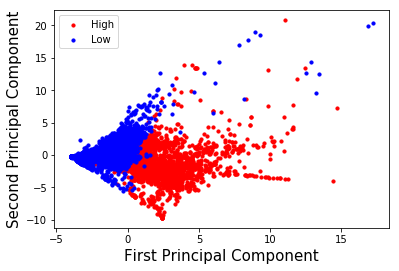

In [5]:
#Question 2


###2a

#Creating the new attribute EnergyLevel

foodscaled['EnergyLevel'] = np.where(food['Energy, with dietary fibre (kJ)'] > 1000, 1, 0)

###2b

#Picking the first 2 principal components (PC)

sklearn_pca = PCA(n_components=2)
foodreduced = sklearn_pca.fit_transform(foodscaled)
foodreduced = pd.DataFrame(foodreduced)


###2c

#Creating two different DataFrames to differentiate the High energy and Low energy foods 

red = foodreduced.loc[foodscaled['EnergyLevel'] == 1]
blue = foodreduced.loc[foodscaled['EnergyLevel'] == 0]

#Plotting the scatter plot using the above dataframes

plt.scatter(red[0], red[1], c='r', label='High', s=10)
plt.scatter(blue[0], blue[1], c='b', label='Low', s=10)
plt.xlabel('First Principal Component',fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)

plt.legend()
plt.show()

__Question 2d__

In the plot, we can see a clear distinction between the High and the Low foods when the first principal component is smaller, and after a threshold which is around 0, the data starts to range widely and more messy. We can observe that the two different food types are quite close to each other rather than being distinct clusters. When we have a very large set of data with many different foods like this one, principal component analysis is used to bring out strong patterns that can be observed within the dataset. Therefore it helps us manage the data in a neater way especially in this dataset which is quite large, however the principal components do not bring out the variation in the best way possible since the two clusters are quite close to each other and are ranging widely.



# 3. Clustering Visualisation

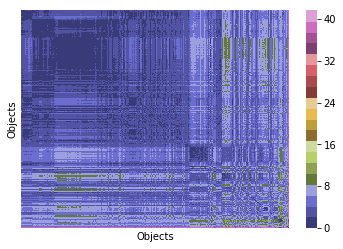

In [6]:
#Question 3


###3a

#Changing the data type using astype then creating the new feature
food['Survey ID'] = food['Survey ID'].astype(str)

foodscaled.insert(2, "Food category", food['Survey ID'].str[:2])

###3b

#Picking the food categories
foodscaledsample = foodscaled[(foodscaled['Food category'] == "24") | (foodscaled['Food category'] == "20") | (foodscaled['Food category'] == "13")]

###3c

#Exclude food category and energy level from heatmap
foodscaledsample = foodscaledsample.drop(columns=['Food category', 'EnergyLevel'])


#RV gives the ordered dissimilarity matrix
RV, C, I = VAT(foodscaledsample)

###3d

#Plotting the heatmap
x=sns.heatmap(RV,cmap='tab20b',xticklabels=False,yticklabels=False) #add vmin)
x.set(xlabel='Objects', ylabel='Objects')
plt.show()

__Question 3e__

There is one clear cluster visible in the heatmap. Since the features Food category and Energy level are not included in the dissimilarity matrix and therefore not plotted in the heatmap, we do expect a smaller distance within the values, therefore more similarity. In theory a qualitative colormap would be the best option to observe differences in the data/colour patterns, however since we have one cluster here the colormap will not make a vast difference.

# 4. K-means and Sum of Squared Errors (SSE)

In [ ]:
foodscaled

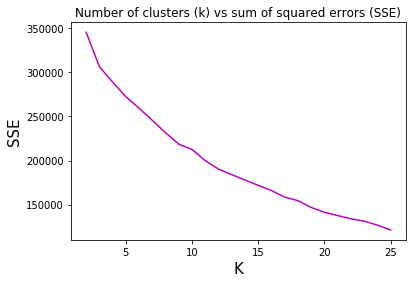

In [8]:
#Question 4

###4a 

X = []

#Creating a list of all the SSE values using the function KMeans and its attribute .intertia_ that gives the sum 
#of squared distances of samples to their closest cluster center
for i in range(2,26):
    kmeans = KMeans(n_clusters=i, random_state=100).fit(foodscaled)
    kmeans.fit(foodscaled)
    labels = kmeans.labels_
    X.append(kmeans.inertia_)

#Plotting the number of clusters(k) versus SSE values corresponding to each k

plt.plot(range(2,26), X, c='m')
plt.xlabel('K',fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.title('Number of clusters (k) vs sum of squared errors (SSE)')

plt.show()

    

__Question 4b__

We can observe that the sum of squared errors (SSE) and the number of clusters (k) are negatively related, meaning when the number of clusters increase, SSE decreases. This agrees with the general logic of a set of data: in a case where there are more clusters, the data tends to seperate neater and be closer to likewise data points. That increases the similarity of the data points within a cluster, and reduces the SSE so it is closer to a 'perfect match'. Thus the shape of the scatter plot is as expected. In theory, elbow might depend on the amount of food categories, and in this case we'd expect to see the elbow around k=25. For that reason, there isn't a clear elbow in the above plot.


# 5. Correlation and Mutual Information

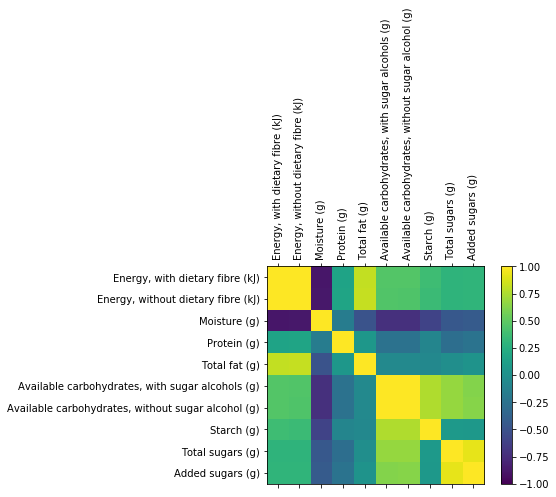

In [9]:
###Question 5


###5a

first10 = food.iloc[:,4:14]


correlations = first10.corr()

# Plotting the correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(first10.columns, rotation=90)
ax.set_yticklabels(first10.columns)
plt.show()


Text(0.5, 1.0, 'Number of bins vs MI of the feature pair')

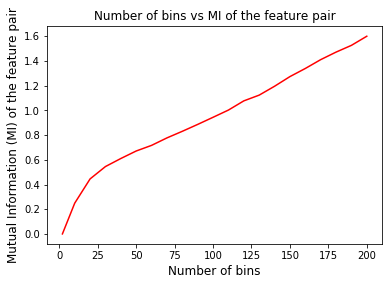

In [10]:
###5b code

#Binning the 2 columns seperately

#Extracting the columns for protein and energy
protein = food.iloc[:,7]
energy = food.iloc[:,4]
MI_list = []

#Creating a list containing bin numbers
bins = [2] + list(range(10, 210, 10))

#Binning each column individually, then putting them together into a dataframe to calculate the Mutual Information
#of the combined dataframe
for i in bins:
    prot_cut = pd.cut(protein, i, labels=False)
    ener_cut = pd.cut(energy, i, labels=False)
    
    conc =[prot_cut, ener_cut]
    df = pd.concat(conc, axis=1)
    MI_list.append(mutual_info(df).get('MI'))

    
#Plotting the graph to see trends

plt.plot(bins, MI_list, c='r')
plt.xlabel('Number of bins',fontsize=12)
plt.ylabel('Mutual Information (MI) of the feature pair', fontsize=12)
plt.title('Number of bins vs MI of the feature pair')

__Question 5b__

We can clearly see that there is a positive relationship between the Mutual information of the feature pair energy-protein and the number of bins. Binning is often used to get a better understanding of the data sample, and in this case when the number of bins increase, the data in a bin becomes more spcific and similar, which means the mutual information also increases considering the mutual information is the measure of mutual dependency. Furthermore, as mentioned above we can observe an elbow when the bin number is close to 25, which was expressed in question 4b.

In [11]:
###5c code

#cont_food is our dataframe with continuous data

#find pearson correlation dataframe for each feature pair
pearson = cont_food.corr(method ='pearson')

#make that dataframe into a dataframe with one column containing all values
cols = [pearson[col].squeeze() for col in pearson]
one_col_df = pd.concat(cols, ignore_index=False)

pears_list = one_col_df.tolist()

one_col_df = pd.DataFrame(one_col_df, columns = ["Column"])

#Get a list of col names to calculate feature pairs
col_names = cont_food.columns


#Add another column that is the other feature of the pair

one_col_df['Pair'] = [col_names[i%53] for i in range(2809)]

#Sort the values of the 1 column dataframe to get 
one_col_df.sort_values("Column")



####MUTUAL INFO

for i in range(53):
    for j in range(53):
        

pearson

NameError: name 'random' is not defined

Question 5c comment here

# 6. Prediction Models: Decision Trees

***
Q6.a: Train Test Split Results
X_train matrix: 4592 , 53
y_train label: 4592
X_test matrix: 1148 , 53
y_test label: 1148
***


Text(0.5, 1.0, 'Maximum depth vs Accuracy')

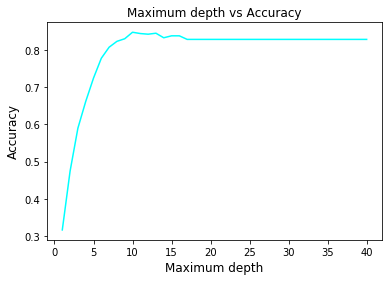

In [12]:
##Question 6


###6a

#Class label is picked as Food category
classlabel=foodscaled['Food category']

#Erasing the food category and energy level columns
foodscaled = foodscaled.drop(columns=['Food category','EnergyLevel'])

#Splitting the data into training and testing data randomly
X_train, X_test, y_train, y_test = train_test_split(foodscaled,classlabel, train_size=0.80, test_size=0.20)

print('***')
print('Q6.a: Train Test Split Results')
print("X_train matrix:", round(X_train.shape[0], 1), ",", round(X_train.shape[1], 1))
print("y_train label:", round(y_train.shape[0], 1))
print("X_test matrix:", round(X_test.shape[0], 1),",", round(X_test.shape[1], 1))
print("y_test label:", round(y_test.shape[0], 1))
print('***')


###6b

max_depth_list = list(range(1, 41))
acc_list = []

#Applying the DecisionTreeClassifier function while incrementing the max depth each time and making a list of accuracy
#values, to later plot maximum depth vs accuracy

for val in max_depth_list:
    dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=val)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    acc_list.append(accuracy_score(y_test, y_pred))

    
#Plotting the line

plt.plot(max_depth_list, acc_list, c='cyan')     
plt.xlabel('Maximum depth',fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Maximum depth vs Accuracy')


__Question 6c__

The plot shows a sharp increase until maximum depth is around 10 and then flattens out, forming an asymptotic line around Accuracy = 1. By definition, the maximum depth will show the complexity of the decision tree model. The formation of the asymptotic line is due to the fact that after a certain point, the accuracy of a decision tree can only change so much that will not affect the information we can obtain from the dataset, and no matter how complex the tree model will be, the accuracy will not be affected (will be but so slightly that it can be ignored).

# 7.  Prediction models: K-NN 

In [13]:
#Question 7

###7a

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

#Applying to X_train
y_pred_train = knn.predict(X_train)

#Applying to X_test
y_pred_test = knn.predict(X_test)


print('***\nQ7.a: Food category prediction using k-NN (k=1)')
print('Train accuracy: ' , round(accuracy_score(y_train, y_pred_train)*100,1), '%')
print('Test accuracy: ' , round(accuracy_score(y_test, y_pred_test)*100,1), '%')
print('***\n')


##7b

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)

#Applying to X_train
y_pred_train3 = knn3.predict(X_train)

#Applying to X_test
y_pred_test3 = knn3.predict(X_test)


print('***\nQ7.b: Food category prediction using k-NN (k=3)')
print('Train accuracy: ' , round(accuracy_score(y_train, y_pred_train3)*100,1), '%')
print('Test accuracy: ' , round(accuracy_score(y_test, y_pred_test3)*100,1), '%')
print('***')

***
Q7.a: Food category prediction using k-NN (k=1)
Train accuracy:  100.0 %
Test accuracy:  89.8 %
***

***
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy:  93.5 %
Test accuracy:  87.1 %
***


__Question 7c__

We can observe that the train accuracy in both cases (a and b) are higher than the test accuracy. This is expected since the training data is larger than the test data because of the formatting of the question. The accuracy levels seem to be higher when k is 1, which is caused by overfitting, thus k=3 gives a more realistic answer.

__Question 7d__

The overly-optimistic accuracies are usually caused by overfitting when K-NN algorithm is executed, where a 100% accuracy would not be expected in any real world datasets. Overfitting happens we have a very large data set but we choose K to be too small, which is the problem with the food dataset. Since compared to the size of the food dataset, k=3 still doesn't make a vast difference than choosing k=1, we do get a very high accuracy level, but a lot more realistic than a 100% accuracy.

# 8. Feature Generation

In [ ]:
#Question 8 code

import random

#METHOD 1: Interaction term pairs

for i in range(53):
    for j in range(52):
        foodscaled['key_%d'%random.choice(range(2809))] = foodscaled.iloc[i,j] * foodscaled.iloc[i, (j+1)]


#METHOD 2:Feature generation with clustering labels

for i in range(2,26):
    kmeans = KMeans(n_clusters=i, random_state=100).fit(foodscaled)
    kmeans.fit(foodscaled)
    labels = kmeans.labels_

foodscaled['Cluster label'] = labels

foodscaled

__Question 8 discussion__

The question 8 algorithm uses most of the techniques implemented in the above questions. The feature generation with the first method however does not provide much of a variety and does not necessarily boost the prediction accuracy. The clustering labels however is a more efficient method to increase the accuracy, and as discussed above when changing the k, we can observe the best results when k is closer/higher than 25 and after that accuracy will not be affected much.